In [35]:

import pandas as pd
import numpy as np
#import ipystata
import seaborn as sns
#import plotly.express as px
import time 
from statsmodels.nonparametric.kernel_regression import KernelReg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial import ConvexHull
from sklearn.kernel_ridge import KernelRidge
from sklearn.cluster import KMeans, MiniBatchKMeans
import statsmodels.api as sm
import statsmodels.formula.api as smf
import gc
from sklearn.neighbors import KNeighborsClassifier

In [ ]:

data = pd.read_stata('proposal.dta')

## Drivers Acceptance Rate - Idle Time 

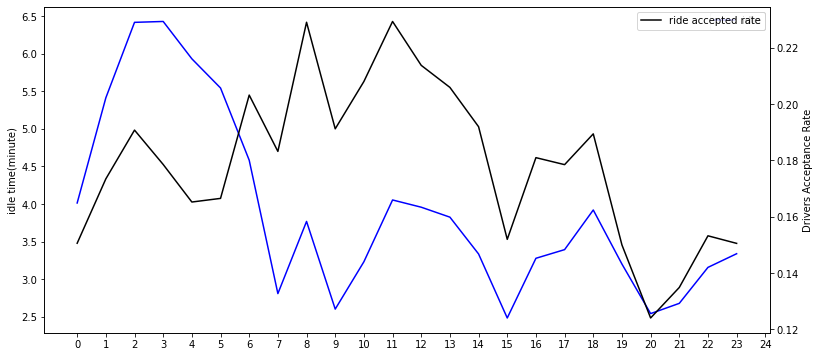

In [13]:
fig, axs = plt.subplots(1, figsize = (13, 6))

hour=data.h.unique()
hour.sort()
idle = data.groupby(['h'])['idle'].mean()
ride_accepted_rate = data.groupby(['h'])['accepted'].mean()

axs.plot(hour,idle[:],label='idle' ,color='blue')
axs.set_xticks(np.arange(0, 25, step=1))
axs.set_ylabel('idle time(minute)')
axs.legend()

axs2=axs.twinx()
axs2.plot(hour,ride_accepted_rate[:],label='ride accepted rate' ,color='black')
axs2.set_ylabel('Drivers Acceptance Rate')
axs2.legend()

## Shift Duration

<AxesSubplot:title={'center':'shiftduration2'}, xlabel='[h]'>

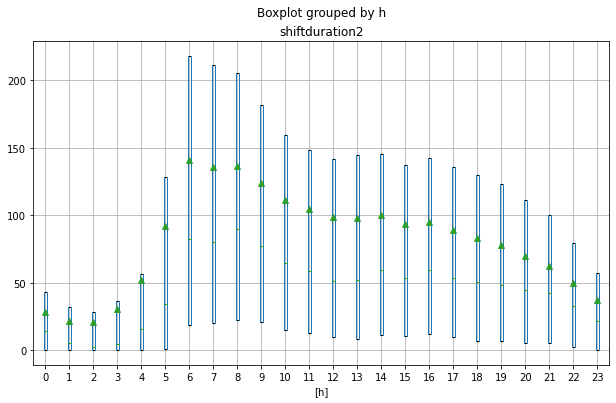

In [14]:
data[(data.entry2==1)][['h','shiftduration2']].boxplot(by='h', showmeans=True,
                                   whis=(25,75), showfliers=False,
                                   widths=0.1, figsize=(10,6))

## Cluster Driver Type based on the Mode of Their Shift Duration

In [ ]:
# finding drivers type based on how long to work
x = data.groupby(['driverId','shift2']).agg( 
                    shiftduration=('shiftduration2','mean')).reset_index()

y = x[(x.shiftduration>30) & (x.shiftduration<600)]

kkmeans = MiniBatchKMeans(n_clusters=2).fit(y[['shiftduration']])
centers2 =  kkmeans.cluster_centers_
y['type2'] = kkmeans.labels_

a = y.groupby('type2').agg(maxx=('shiftduration','max'),
                          minn=('shiftduration','min'))
y.sort_values(['driverId'])

drivertype = y.groupby('driverId')[['type2']].apply(lambda x:
                                                        x.mode().iloc[0]).reset_index()
data = data.merge(drivertype[['driverId','type2']], on='driverId', how='left')
del x ,y

In [85]:
# prefered locations
 
entrance = data[(data.entry==1) & ((data.h>=6) & (data.h<10))].groupby('driverId')[['c']].apply(
                                                 lambda x: x.mode().iloc[0])

quitt = data[(data.exitt==1) & ((data.h>=21) & (data.h<25))].groupby('driverId')[['c']].apply(
                                                     lambda x: x.mode().iloc[0])
entrance= entrance.merge(quitt, on='driverId', how='outer')
entrance['homec'] = entrance['c_x']

entrance['homec']=entrance['homec'].fillna(value=entrance['c_y'])
entrance = entrance.reset_index()
data = data.merge(entrance, on='driverId', how='left')


data['tohome']=data['d']-data['homec']
data.loc[data['tohome']!=0, ['tohome']]=1
 
timetake_tohome= data[data.ll==1].groupby(['c','d','h'])['time'].mean().reset_index()
timetake_tohome = timetake_tohome.rename(columns={'d':'homec','time':'quittohome'})
data = data.merge(timetake_tohome, on=['c','homec','h'], how='left')
timetake_tohome= data[data.ll==1].groupby(['c','d','h'])['time3'].mean().reset_index()
timetake_tohome = timetake_tohome.rename(columns={'c':'d', 'd':'homec' ,'time3':'dropofftohome'})
data = data.merge(timetake_tohome, on=['d','homec','h'], how='left') 
del entrance
del timetake_tohome

In [117]:
#data['truetaostate'] = round(data['trutao']/30) 
supply = data.groupby(['driverId','shift2','truetaostate']).agg(
        totalaccepted=('totalaccepted','mean'),
        h=('h','max'),
        Earning_sofar=('earningsofarbad2','max'),
        Shift_duration=('trutao','max'),
        shiftduration=('shiftduration2','mean'),
        fulltime=('type2_x','max'),       
        quittohome=('quittohome','mean'),
        Waitingtime=('idle','mean'),
        exitt = ('exitt2','sum'),
        entry=('entry2','sum'),
        passincarsofar=('passincarsofarbad','max')).reset_index()


In [268]:
def coef_plot(state, xvar, std, coef):
    n = len(xvar)

    materials = [str(x*30) for x in state]
    x_pos = np.arange(len(materials))
    fig, axs = plt.subplots(n, figsize=(12,20))
    for i in range(n):
        
        price = coef.loc[coef.index==xvar[i]].values.tolist()[0]
        priceerror = std.loc[std.index==xvar[i]].values.tolist()[0]

        axs[i].barh(x_pos, price, xerr=priceerror, alpha=0, capsize=10, ecolor='black')

        axs[i].set_yticks(x_pos)
        axs[i].set_yticklabels(materials)
        axs[i].set_title('Coefficient of {} over day'.format(xvar2[i]), color='blue')
        axs[i].set_ylabel('How long already in a shift (min.)')

        axs[i].axvline(x=0 ,linestyle='--', color='blue', linewidth=2)

        plt.tight_layout()
    plt.show()
    return()

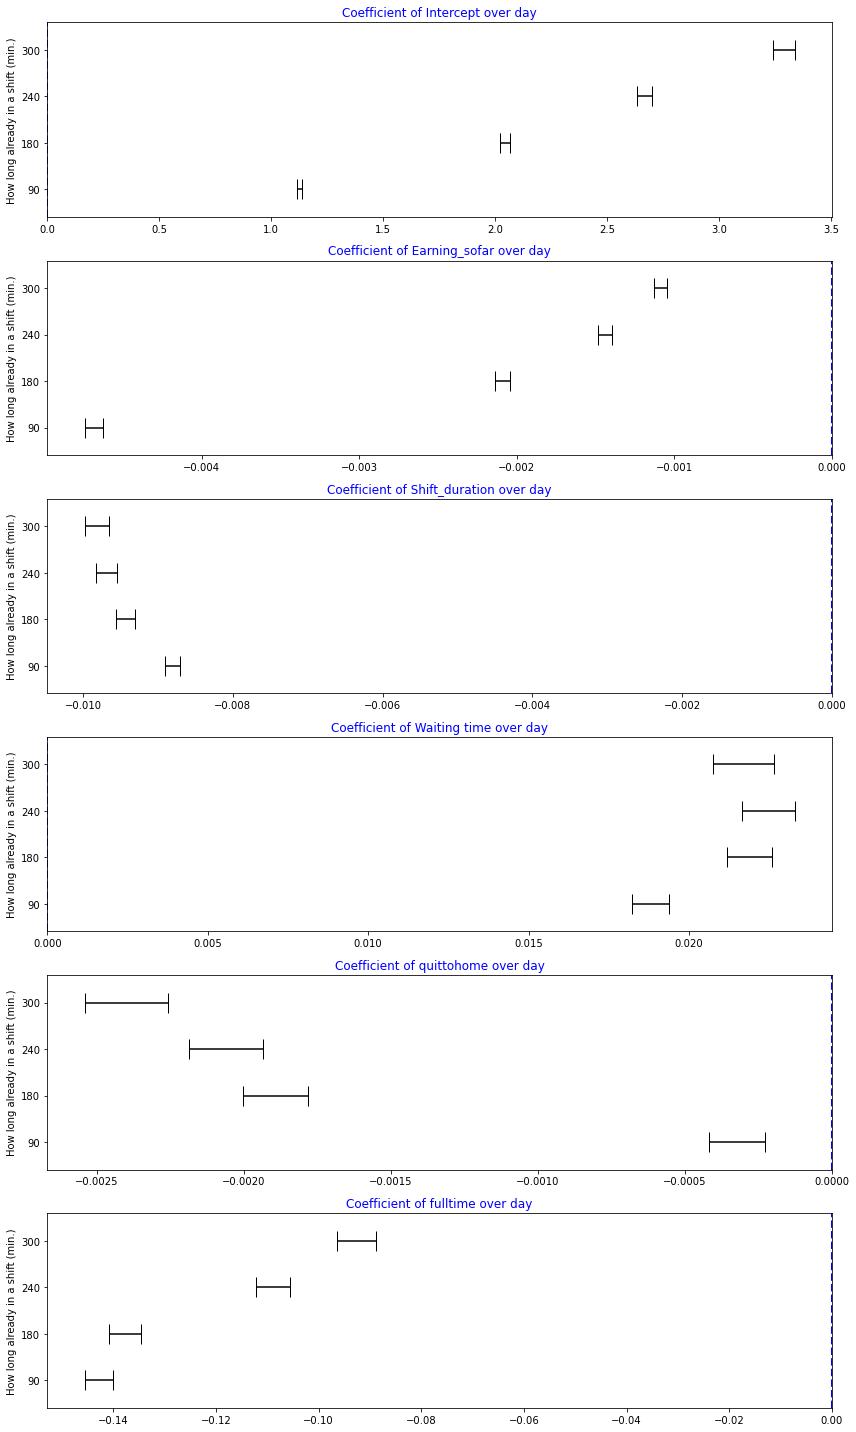

()

In [269]:
xvar = ['Intercept' ,'Earning_sofar' ,  'Shift_duration' , 'Waitingtime' , 'quittohome' , 'fulltime']
coef = pd.DataFrame(index=xvar)
std = pd.DataFrame(index=xvar)
state = [3,6,8,10]
for i in state:
    a = smf.ols(formula='exitt ~  Earning_sofar +  Shift_duration + Waitingtime + quittohome + fulltime', 
                  data=supply[supply.truetaostate==i]).fit()
    coef =  coef.merge(a.params.rename(i), left_index=True, right_index=True)
    std =  std.merge(a.bse.rename(i), left_index=True, right_index=True)
coef_plot(state, xvar,  std, coef)

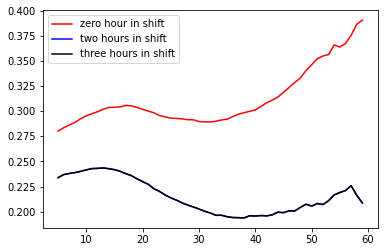

In [10]:

neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(data[['shiftduration','time']], data['accepted'])
hname = ['zero','two', 'three']   
X = np.arange(5,60)
X2 = np.ones(60-5)

    for i in range(0,4 ,6):
        plt.plot(X ,neigh.score(X,X2*i), color='r', label='{} hour in shift'.format(hname[i]))
   
    plt.legend()
    plt.show()

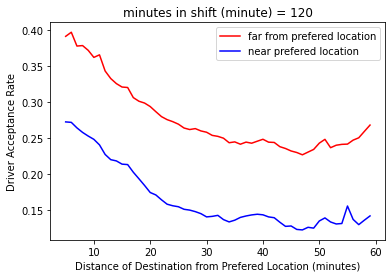

In [19]:
#preferred location

neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(data[data.shiftduration==120][['quittohome','dropofftohome']], data['accepted'])
hname = ['zero','two', 'three']   
X = np.arange(5,60)
X2 = np.ones(60-5)



plt.plot(X, neigh(X2*120,X ) color='r', label='far from prefered location')
plt.plot(X, neigh(X2*20,X ) color='b', label='near prefered location')
plt.xlabel("Distance of Destination from Prefered Location (minutes)")
plt.ylabel("Driver Acceptance Rate")
plt.title('minutes in shift (minute) = 120 ')
plt.legend(loc='upper right')
plt.show()